In [404]:
%reset -f
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

In [405]:
# Here we have our white noise, a gaussian variable of mean 0 and varaince sigma2
def white_noise(mean,sigma,number_variables):
    """This Function here returns a White noise"""
    return np.random.normal(mean,sigma,number_variables)

#  Here we have the white AR sequence, built from an initial gaussian varaible
def AR(p,phis,sigma,number_variables):
    """This Function here returns an AR process"""
    # Initializing the random process
    AR_process = white_noise(0,sigma,number_variables)
    # Building the AR process recursively
    for variable in range(number_variables):
        for shift in range(p):
            AR_process[variable] += (phis[shift] * AR_process[variable-shift-1]) 
    return AR_process

# Computing the Power spectral density of AR process
def spectral_density(nu,phis,sigma):
    # Computing the roots of the polynome. nu represents the angles 
    roots = np.roots(phis)
    # Computing the distance between the roots and the unit circle
    expos = 1
    for root in roots:
        expos *= np.abs(1/(np.exp(1j*nu) - root))**2
    # returning the matrix
    return ((sigma**2)/2*np.pi)*expos

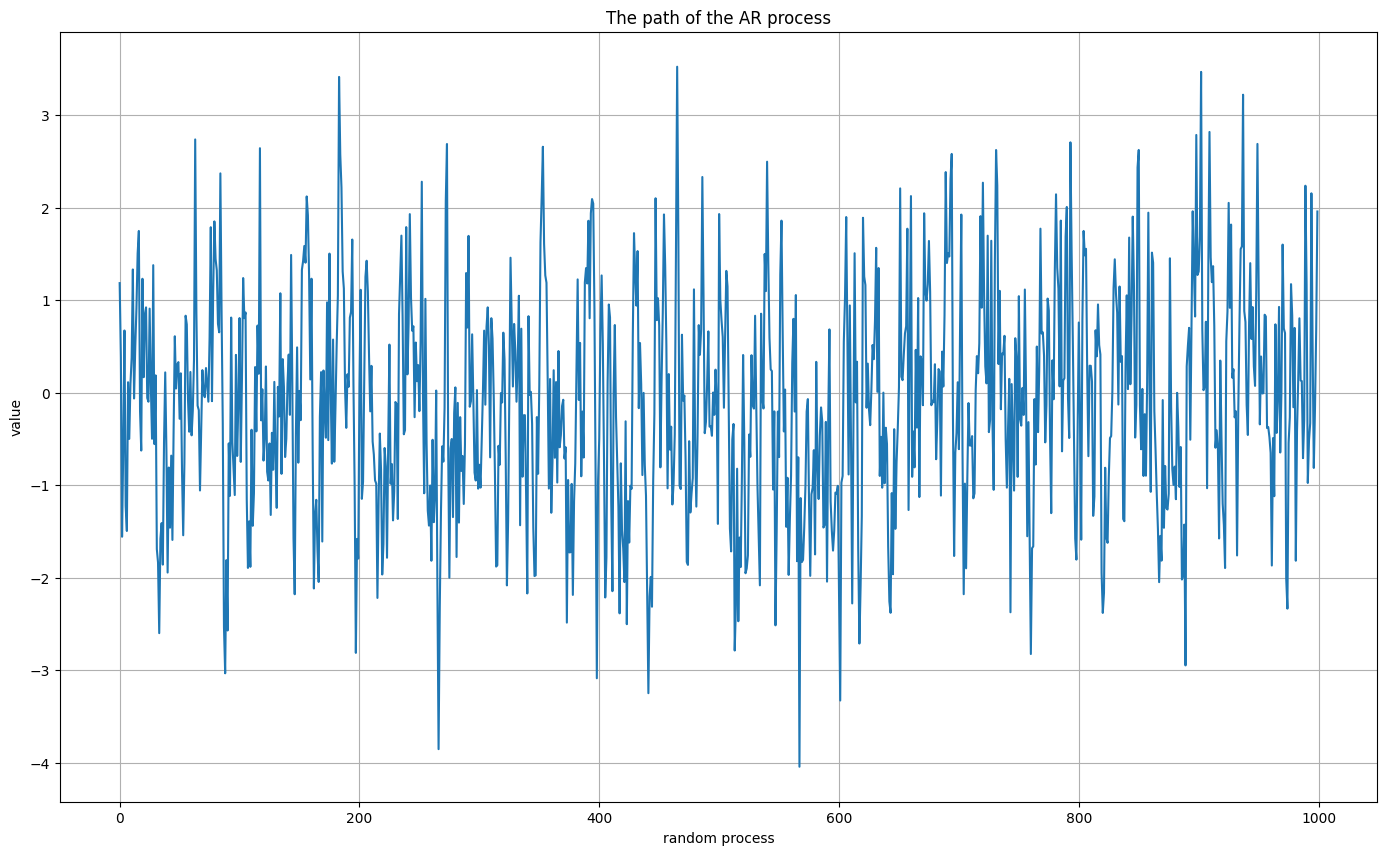

In [406]:
PHIS = np.array([0.55,-0.7,0.3,0.1]) 
PHI = np.array([0.55])
SIGMA = 1
# AR_process for p = 1
AR_process = AR(1, PHIS, SIGMA, 1_000)

plt.figure(figsize=(17,10))
plt.grid()
plt.plot(AR_process)
plt.xlabel('random process')
plt.ylabel('value')
plt.title("The path of the AR process")
plt.show()

In [407]:
def Bartlett(signal, L):
    """Compute the Bartlett periodogram estimate"""
    N = len(signal)
    assert L <= N
    M = N // L
    periodogram_inter = []

    for i in range(1, L + 1):  
        signal_inter = signal[(i-1) * M : (i-1) * M + M]  
        periodogram_inter.append(
            (1 / M) * np.abs(np.fft.fft(signal_inter))**2  
        )

    return np.mean(periodogram_inter, axis = 0)  

def periodogram(signal, fs =1, L=2, method="standard"):
    """Compute the periodogram using different methods"""
    N = len(signal)

    if method == "standard":
        result = (1 / N) * np.abs(np.fft.fft(signal))**2
        f = np.fft.fftfreq(N, d=1/fs)
        f = np.fft.fftshift(f)
        result = np.fft.fftshift(result)
        return f, result

    elif method == "Bartlett":
        result = Bartlett(signal, L)
        f = np.fft.fftfreq(N//L, d=1/fs)
        f = np.fft.fftshift(f)
        result = np.fft.fftshift(result)
        return f , result

    elif method == "Welch":
        M = N//L
        f, result = sp.signal.welch(signal, nperseg=M//2)
        f_len = len(f)
        f_full = np.fft.fftshift(
            np.fft.fftfreq(2*f_len, d=1/fs)
        )
        result = np.concatenate((np.flip(result),result))
        return f_full, result

    else:
        raise ValueError("Please choose an appropriate method from: standard, Bartlett, and Welch")


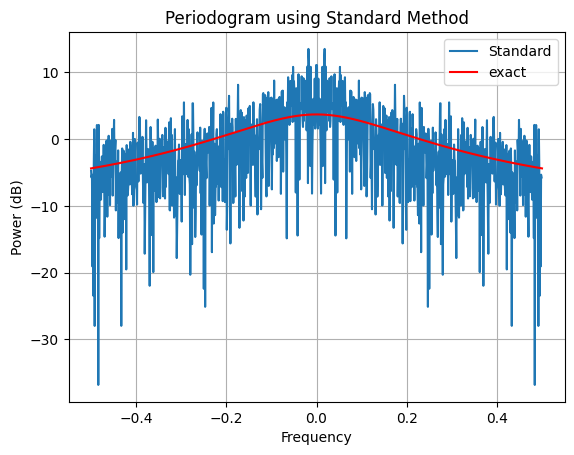

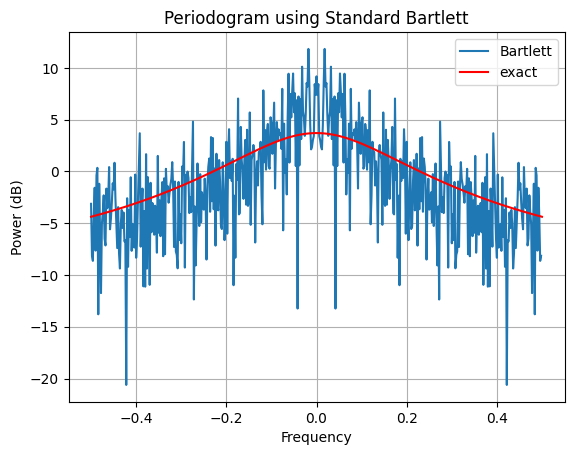

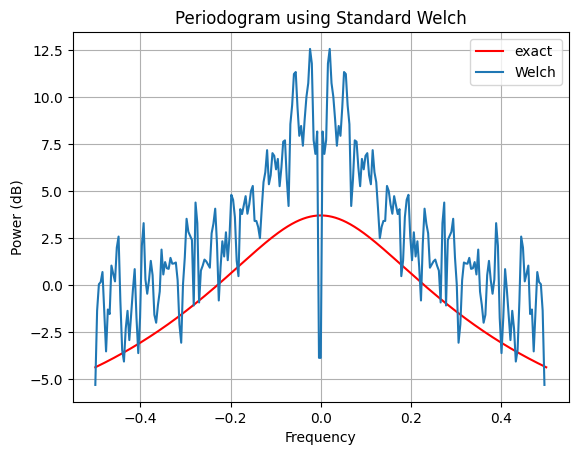

In [408]:
f, periodogram_standard = periodogram(signal=AR_process)
f_bartlett, Bartlett_periodogram = periodogram(signal=AR_process, method="Bartlett")
f_welch, Welch_periodogram = periodogram(signal=AR_process, method="Welch")
f_exact, PSD_exact = sp.signal.periodogram(AR_process, window='hann')

_phi = np.flip(
    np.append([1],-PHI)
    )
nu = np.linspace(-np.pi/2, np.pi/2, 1_000)
nu_demi = np.linspace(-1/2, 1/2, 1_000)
theoritical_spectral = spectral_density(nu, _phi, SIGMA)

# Plotting the Graph
plt.figure()
plt.plot(f, 10*np.log10(periodogram_standard), label="Standard")
plt.plot(nu_demi, 10*np.log10(theoritical_spectral), label="exact",color='red')
plt.legend()
plt.xlabel("Frequency")
plt.ylabel("Power (dB)")
plt.title("Periodogram using Standard Method")
plt.grid()

plt.figure()
plt.plot(f_bartlett, 10*np.log10(Bartlett_periodogram), label="Bartlett")
plt.plot(nu_demi, 10*np.log10(theoritical_spectral), label="exact", color='red')
plt.grid()
plt.legend()
plt.xlabel("Frequency")
plt.ylabel("Power (dB)")
plt.title("Periodogram using Standard Bartlett")
plt.show()

plt.figure()
plt.plot(nu_demi, 10*np.log10(theoritical_spectral), label="exact",color='red')
plt.plot(f_welch, 10*np.log10(Welch_periodogram), label="Welch")
plt.legend()
plt.xlabel("Frequency")
plt.ylabel("Power (dB)")
plt.title("Periodogram using Standard Welch")
plt.grid()
plt.show()


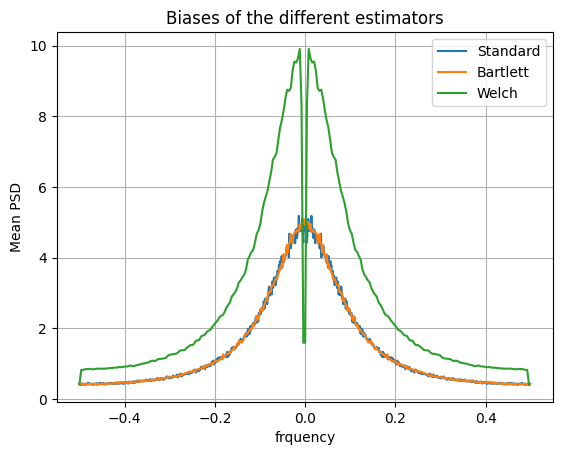

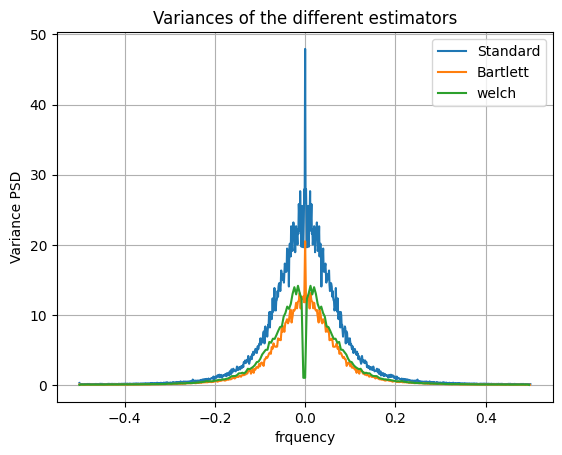

In [409]:
def bias_var_calculator_AR(p, phis, sigma, numebr_variables, method):
    """ Bias and Variance Caluclator for the periodogram of an AR process"""
    
    number_tests = 1_000
    AR_process = AR(p, phis, sigma, numebr_variables)
    f, _ = periodogram(AR_process, method=method)
    periodogram_list = np.zeros((1_000, len(f)))
    
    for i in range(number_tests):
        AR_process = AR(1, PHI, SIGMA, 1_000)
        _, periodogram_inter = periodogram(AR_process, method=method)
        periodogram_list[i, :] = periodogram_inter

    bias_process = np.mean(periodogram_list, axis=0)
    var_process = np.var(periodogram_list, axis=0)
    
    return bias_process, var_process


bias_standard, var_standard = bias_var_calculator_AR(1, PHI, SIGMA, 1_000, method="standard")
bias_barlett, var_barlett = bias_var_calculator_AR(1, PHI, SIGMA, 1_000, method="Bartlett")
bias_welch, var_welch = bias_var_calculator_AR(1, PHI, SIGMA, 1_000, method="Welch")


plt.figure()
plt.title("Biases of the different estimators")
plt.grid()
plt.xlabel("frquency")
plt.ylabel("Mean PSD")
plt.plot(f, bias_standard, label="Standard")
plt.plot(f_bartlett, bias_barlett, label="Bartlett")
plt.plot(f_welch, bias_welch, label = "Welch")
plt.legend()
plt.show()

plt.figure()
plt.grid()
plt.title("Variances of the different estimators")
plt.xlabel("frquency")
plt.ylabel("Variance PSD")
plt.plot(f, var_standard, label="Standard")
plt.plot(f_bartlett, var_barlett, label="Bartlett")
plt.plot(f_welch, var_welch, label="welch")
plt.legend()
plt.show()

the Gamma matrix is :
 [[1.51358571 0.87974764]
 [0.87974764 1.51358571]]

the approximated phis are: [0.58123411] while the initial phis are: [0.55] 

the approximated sigma is: 1.0011225577528782 while the initial sigma is: 1



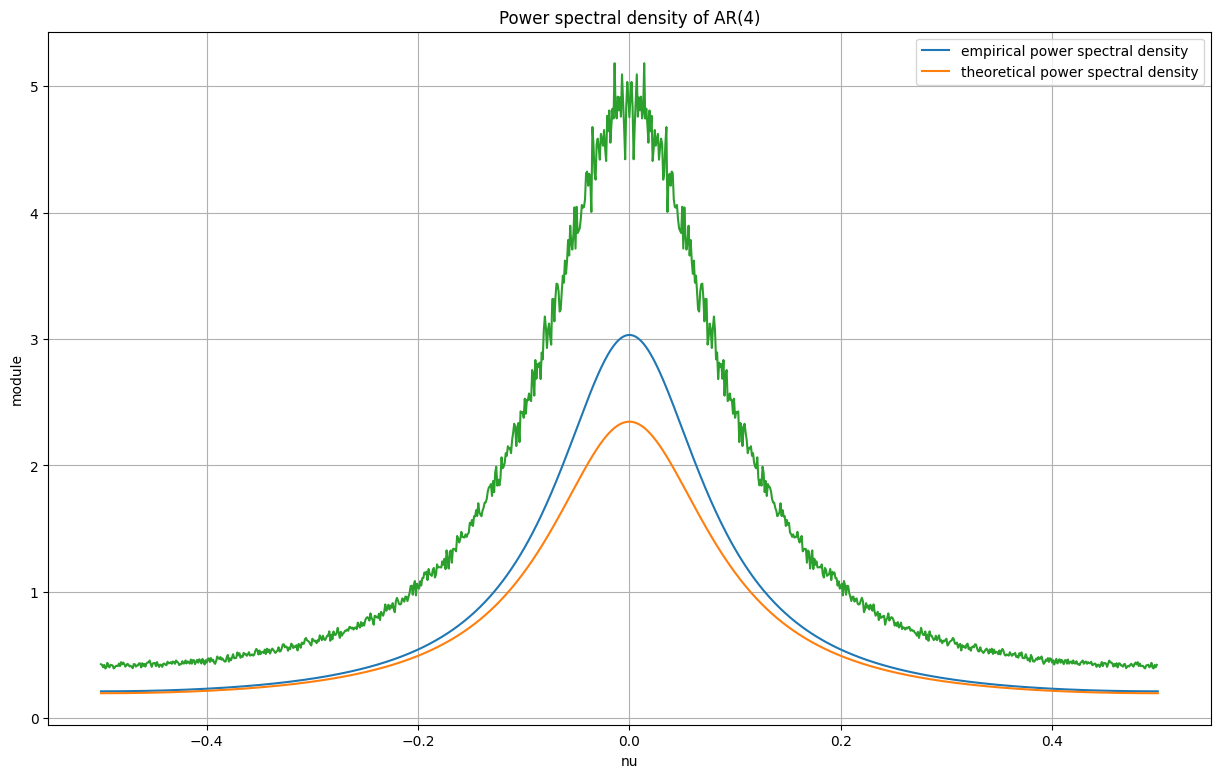

In [410]:
# Computing the empirical mean of the random varaibles
def empirical_mean(X):
    assert(len(X) != 0)
    return np.mean(X)

# Computing the empirical autocovaraince of the random process
def empirical_autocovariance(X, taus):
    # Initializing the lenght and the tau matrix
    N = len(X)
    X_sum = np.zeros(len(taus))    
    # Computing the autocovaraince
    for tau, k in enumerate(taus):
        X_shifted = X[k:N] - empirical_mean(X)
        X_original = X[0:N-k] - empirical_mean(X)
        X_sum[tau] = (1/N)  * np.sum(X_shifted * X_original)
    
    return X_sum   

def Gamma(p, signal):

    # Initializing the i,js of the matrix
    taus = np.arange(0,p+1)
    # Computing the empirical autocovaraince 
    empirical_autocov = empirical_autocovariance(signal,taus=taus)
    # Generating the Toeplitz Gamma(p+1) matrix using scipy  
    gamma = sp.linalg.toeplitz(empirical_autocov)
    
    # Approximating the phis and the sigma2

    # Computing the [1/sigma2, phi1/sigm2 , ... , phip/sigm2] using the equation(1)
    approximation = np.linalg.inv(gamma) @ np.array([1 if v == 0 else 0 for v in range(p+1)]).T

    # Computing the sigma2 and the phi coefficients 
    sigma_approximation_square = 1/approximation[0]
    empirical_phis = -(sigma_approximation_square*approximation[1:])
    sigma_approximation = np.sqrt(sigma_approximation_square)
    
    # Returning the matrix, the sigma2 and the empirical phis
    return gamma , sigma_approximation , empirical_phis


# getting the angles between [-pi,pi] 
nu = np.linspace(-np.pi, np.pi, 1_000)
# Computing the empirical and theoritical spectral densities
AR_process = AR(1, PHI, SIGMA, 1_000)
gamma_4 , sigma_approximation , empirical_phis = Gamma(1, AR_process)

# First we define the polynome coeffifients, we flip the [1,-phi] matrixes since the numpy root method does so
_empirical_phis = np.flip(
    np.append([1],-empirical_phis)
    )

_phi = np.flip(
    np.append([1],-PHI)
    )

print(f"the Gamma matrix is :\n {gamma_4}\n")
print(f"the approximated phis are: {empirical_phis} while the initial phis are: {PHI} \n")
print(f"the approximated sigma is: {sigma_approximation} while the initial sigma is: {SIGMA}\n")

empirical_spectral = spectral_density(nu, _empirical_phis, sigma_approximation)
theoritical_spectral = spectral_density(nu, _phi, SIGMA)

# Plotting the spectral density using the roots method
plt.figure(figsize=(15,9))
plt.grid()
plt.plot(nu_demi, empirical_spectral)
plt.plot(nu_demi, theoritical_spectral)
plt.plot(f, bias_standard)
plt.xlabel("nu")
plt.ylabel("module")
plt.title("Power spectral density of AR(4)")
plt.legend(["empirical power spectral density","theoretical power spectral density"])
plt.show()

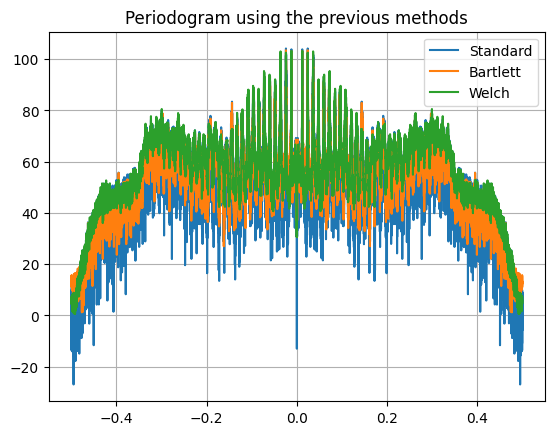

In [411]:
import wave, struct, pyaudio

def load_sound(file):
    return wave.open(file, 'rb')

def play_sound(file, chunk = 1024):
    """
    Script from PyAudio doc
    """
    wf = load_sound(file)
    p = pyaudio.PyAudio()
    stream = p.open(format=p.get_format_from_width(wf.getsampwidth()),
                    channels=wf.getnchannels(),
                    rate=wf.getframerate(),
                    output=True)
    data = wf.readframes(chunk)

    while data:
        stream.write(data)
        data = wf.readframes(chunk )

    stream.stop_stream()
    stream.close()
    p.terminate()

wavefile = load_sound("aeiou.wav")

Fs = int(wavefile.getframerate())
num_samples = int(wavefile.getnframes())
data = wavefile.readframes(num_samples)
data = struct.unpack('{n}h'.format(n=num_samples), data)
x = np.array(data)


f_aeiou, standard = periodogram(x)
f_aeiou_bartlett, bartlett = periodogram(x, method="Bartlett")
f_aeiou_welch, welch = periodogram(x, method="Welch")

plt.figure()
plt.grid()
plt.title("Periodogram using the previous methods")
plt.plot(f_aeiou, 10*np.log10(standard), label="Standard")
plt.plot(f_aeiou_bartlett, 10*np.log10(bartlett), label="Bartlett")
plt.plot(f_aeiou_welch, 10*np.log10(welch), label="Welch")
plt.legend()
plt.show()


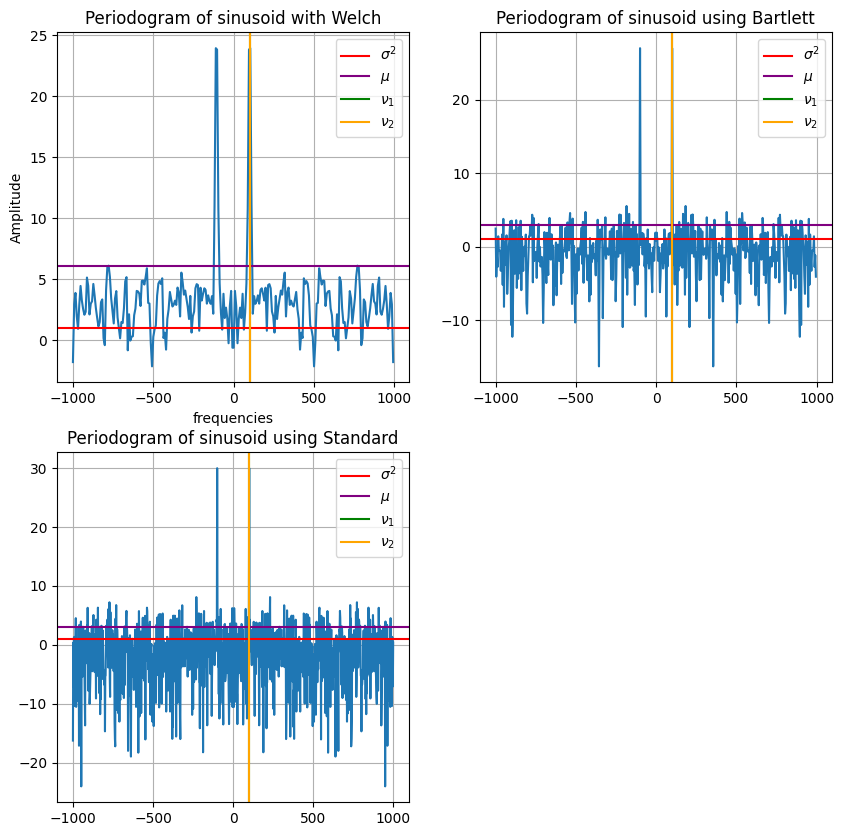

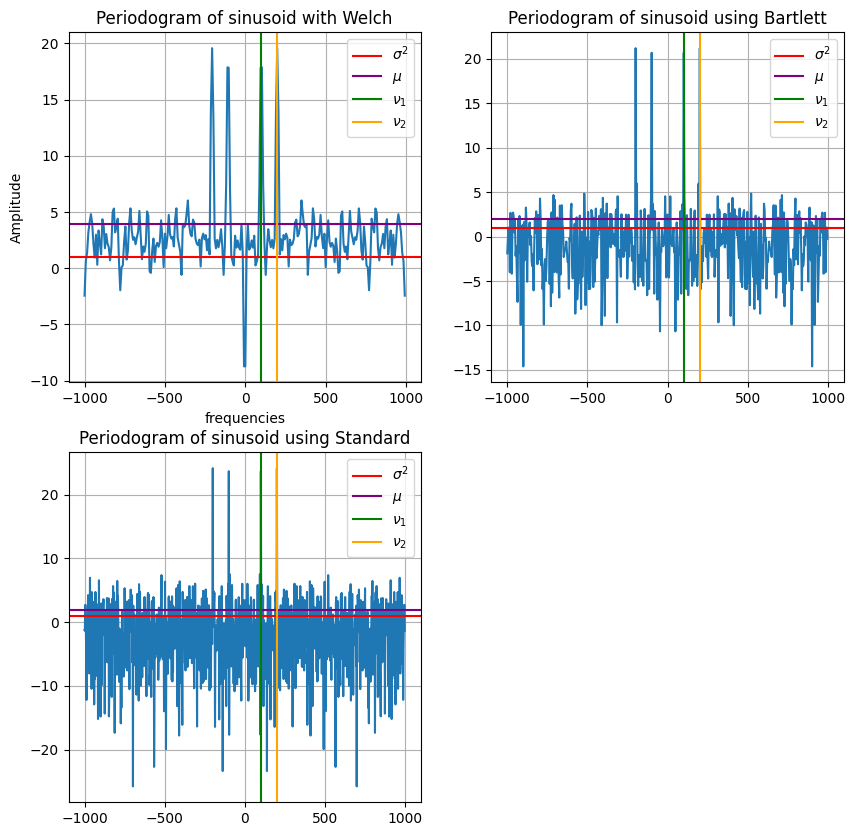

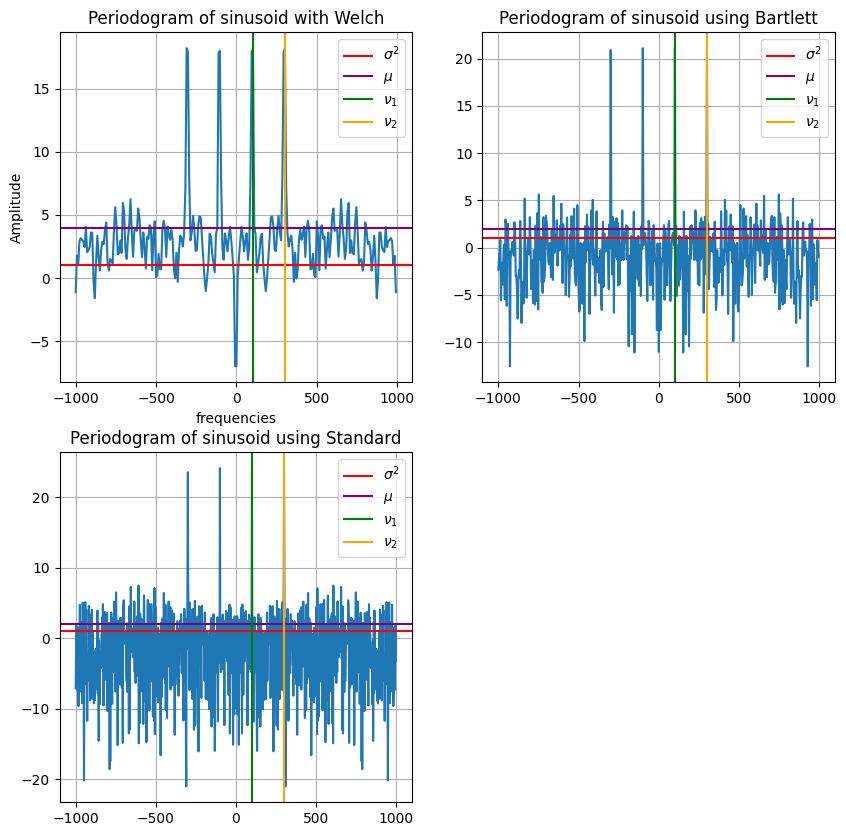

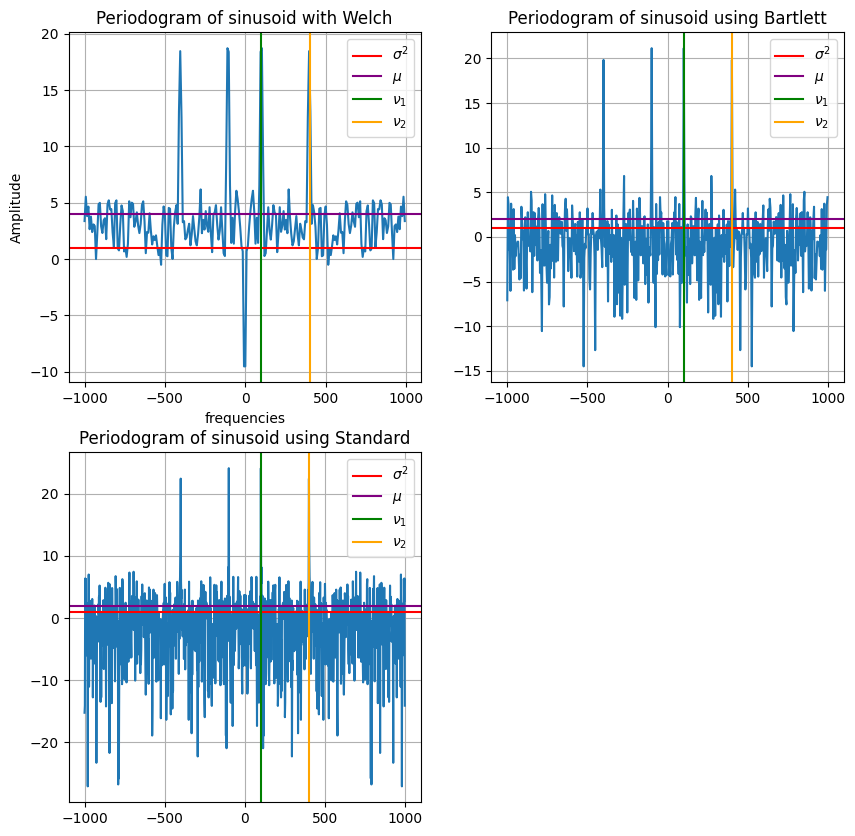

In [412]:
def sinusoidal(Amplitudes, frequencies, fs, timesteps, phases, sigma):
    """Generate a sum of K sinusoids plus white noise"""
    
    K = len(frequencies)
    y = np.zeros((len(timesteps),K))
    Z = white_noise(0, sigma, number_variables=(len(timesteps)))
    for i in range(K):
        y[:, i] = Amplitudes[i] * np.sin(2* np.pi * (frequencies[i]/fs) * timesteps + phases[i])
    return np.sum(y, axis=1) + Z

def plotting_sinusoidals(sinusoidal_signal, nus, fs, sigma=SIGMA):
    """ Function to plot sinusoidals"""

    f, standard_sinusoidal = periodogram(sinusoidal_signal, fs=fs)
    f_bartlett , bartlett_sinusoidal = periodogram(sinusoidal_signal, method = "Bartlett", fs=fs)
    f_welch, welch_sinusoidal = periodogram(sinusoidal_signal, method="Welch", fs=fs)
    mean_welch = np.mean(welch_sinusoidal)
    mean_bartlett = np.mean(bartlett_sinusoidal)
    mean_standard = np.mean(standard_sinusoidal)

    fig, ax = plt.subplots(2, 2, figsize=(10,10))
    fig.delaxes(ax[1,1])

    ax[0,0].grid()
    ax[0,0].set_xlabel("frequencies")
    ax[0,0].set_ylabel("Amplitude")
    ax[0,0].plot(f_welch, 10*np.log10(welch_sinusoidal))
    ax[0,0].set_title("Periodogram of sinusoid with Welch")
    ax[0,0].axhline(sigma**2, color="red", label=r"$\sigma^2$")
    ax[0,0].axhline(mean_welch, color="purple", label=r"$\mu$")
    ax[0,0].axvline(nus[0], color="green", label=r"$\nu_{1}$")
    ax[0,0].axvline(nus[1], color="orange", label=r"$\nu_{2}$")
    ax[0,0].legend()

    ax[0,1].plot(f_bartlett, 10*np.log10(bartlett_sinusoidal))
    ax[0,1].set_title("Periodogram of sinusoid using Bartlett")
    ax[0,1].axhline(sigma**2, color="red", label=r"$\sigma^2$")
    ax[0,1].axhline(mean_bartlett, color="purple", label=r"$\mu$")
    ax[0,1].axvline(nus[0], color="green", label=r"$\nu_{1}$")
    ax[0,1].axvline(nus[1], color="orange", label=r"$\nu_{2}$")
    ax[0,1].grid()
    ax[0,1].legend()

    ax[1,0].plot(f, 10*np.log10(standard_sinusoidal))
    ax[1,0].set_title("Periodogram of sinusoid using Standard")
    ax[1,0].axhline(sigma**2, color="red", label=r"$\sigma^2$")
    ax[1,0].axhline(mean_standard, color="purple", label=r"$\mu$")
    ax[1,0].axvline(nus[0], color="green", label=r"$\nu_{1}$")
    ax[1,0].axvline(nus[1], color="orange", label=r"$\nu_{2}$")
    ax[1,0].grid()
    ax[1,0].legend()

    plt.show()

nu_1 = 100
nu_2 = np.arange(100, 500, 100)
Fs = 2_000
amplitudes = [1, 1]
timesteps = np.linspace(0, 1_000, 1_000)
phases = np.zeros(2)

for i in nu_2:
    nus = [nu_1, i]
    signal_sinousial = sinusoidal(
        amplitudes, nus, Fs, timesteps, phases, SIGMA
    )
    plotting_sinusoidals(signal_sinousial, nus, Fs, SIGMA)


In [413]:
PHIS = np.array([0.55,-0.7,0.3,0.1]) 
AR_process_4 = AR(4, PHIS, SIGMA, 1_000)

the Gamma matrix is :
 [[ 2.18987287  0.45940051 -1.27277598 -0.36842813  1.0525569 ]
 [ 0.45940051  2.18987287  0.45940051 -1.27277598 -0.36842813]
 [-1.27277598  0.45940051  2.18987287  0.45940051 -1.27277598]
 [-0.36842813 -1.27277598  0.45940051  2.18987287  0.45940051]
 [ 1.0525569  -0.36842813 -1.27277598  0.45940051  2.18987287]]

the approximated phis are: [ 0.50996577 -0.66204907  0.23947341  0.1314178 ] while the initial phis are: [ 0.55 -0.7   0.3   0.1 ] 

the approximated sigma is: 1.0309501494338833 while the initial sigma is: 1



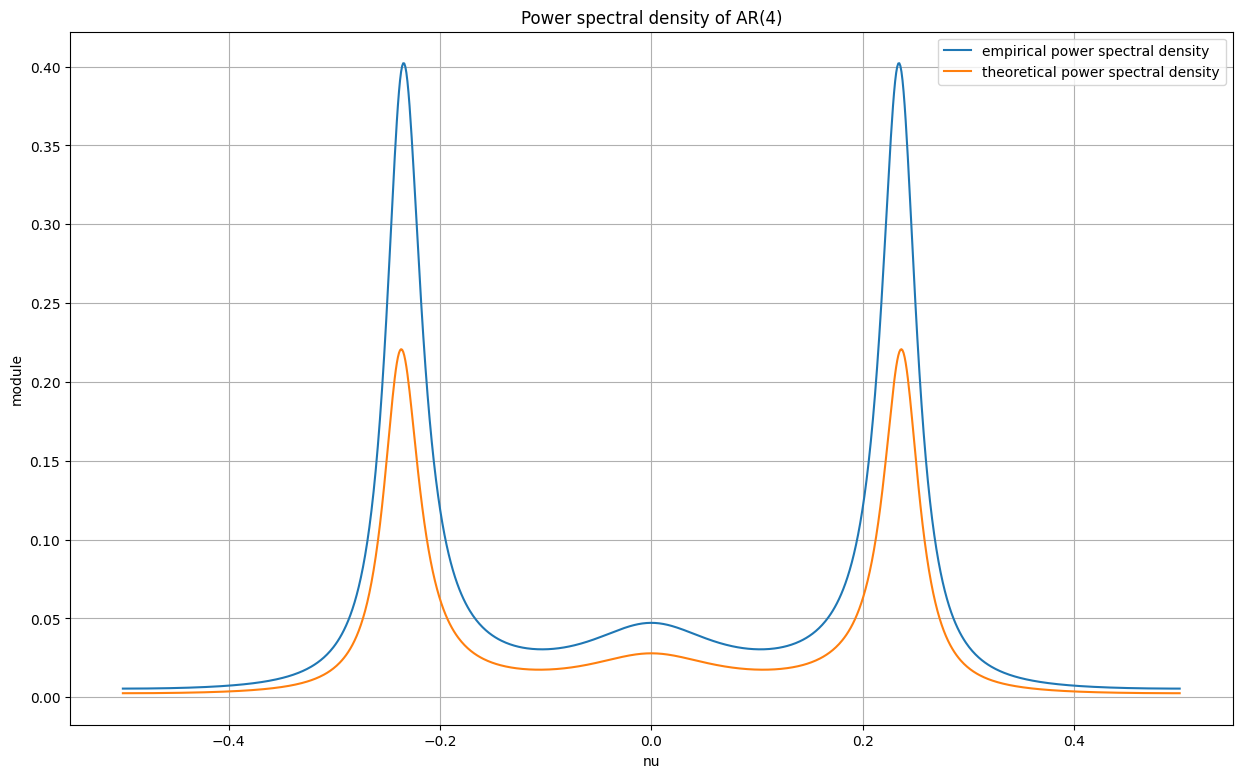

In [414]:
gamma_4 , sigma_approximation , empirical_phis = Gamma(4, AR_process_4)

# First we define the polynome coeffifients, we flip the [1,-phi] matrixes since the numpy root method does so
_empirical_phis = np.flip(
    np.append([1],-empirical_phis)
    )

_phi = np.flip(
    np.append([1],-PHIS)
    )

print(f"the Gamma matrix is :\n {gamma_4}\n")
print(f"the approximated phis are: {empirical_phis} while the initial phis are: {PHIS} \n")
print(f"the approximated sigma is: {sigma_approximation} while the initial sigma is: {SIGMA}\n")

empirical_spectral = spectral_density(nu, _empirical_phis, sigma_approximation)
theoritical_spectral = spectral_density(nu, _phi, SIGMA)
f_bartlett, bartlett = periodogram(AR_process_4, method="Bartlett")

# Plotting the spectral density using the roots method
plt.figure(figsize=(15,9))
plt.grid()
plt.plot(nu_demi, empirical_spectral)
plt.plot(nu_demi, theoritical_spectral)
# plt.plot(f_bartlett, 10*np.log10(bartlett))
plt.xlabel("nu")
plt.ylabel("module")
plt.title("Power spectral density of AR(4)")
plt.legend(["empirical power spectral density","theoretical power spectral density"])
plt.show()


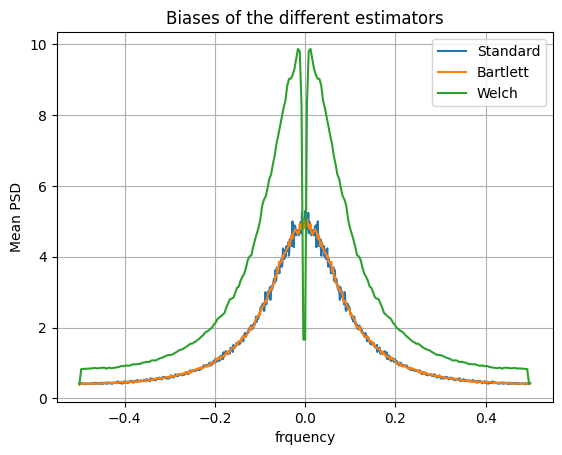

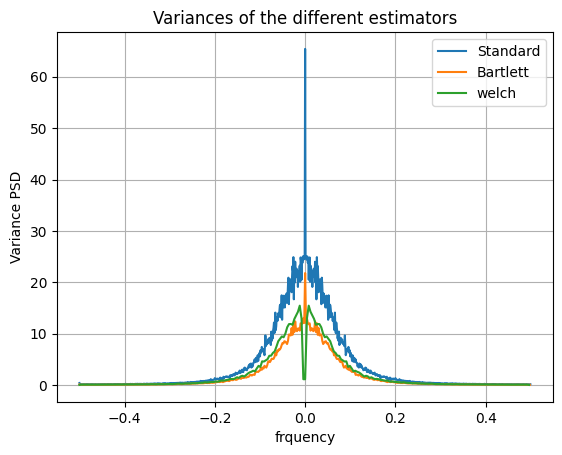

In [415]:
bias_standard, var_standard = bias_var_calculator_AR(4, PHIS, SIGMA, 1_000, method="standard")
bias_barlett, var_barlett = bias_var_calculator_AR(4, PHIS, SIGMA, 1_000, method="Bartlett")
bias_welch, var_welch = bias_var_calculator_AR(4, PHIS, SIGMA, 1_000, method="Welch")


plt.figure()
plt.title("Biases of the different estimators")
plt.grid()
plt.xlabel("frquency")
plt.ylabel("Mean PSD")
plt.plot(f, bias_standard, label="Standard")
plt.plot(f_bartlett, bias_barlett, label="Bartlett")
plt.plot(f_welch, bias_welch, label = "Welch")
plt.legend()
plt.show()

plt.figure()
plt.grid()
plt.title("Variances of the different estimators")
plt.xlabel("frquency")
plt.ylabel("Variance PSD")
plt.plot(f, var_standard, label="Standard")
plt.plot(f_bartlett, var_barlett, label="Bartlett")
plt.plot(f_welch, var_welch, label="welch")
plt.legend()
plt.show()

In [416]:
def Capon(signal, nu):
    N = len(signal)
    taus = np.arange(0, N)
    empirical_autocov = empirical_autocovariance(signal,taus=taus)
    # Generating the Toeplitz Gamma(p+1) matrix using scipy  
    R_xx = sp.linalg.toeplitz(empirical_autocov)
    e_nu = np.exp(2j * np.pi * nu * taus)
    e_nu_hat = np.conjugate(e_nu)
    return N / (e_nu_hat.T @ np.linalg.inv(R_xx) @ e_nu)

nus = np.linspace(-1/2, 1/2, 100)
result = []
for nu in nus:
    inter = pow(
        np.abs(Capon(signal_sinousial, nu)), 2
    )
    result.append(inter)

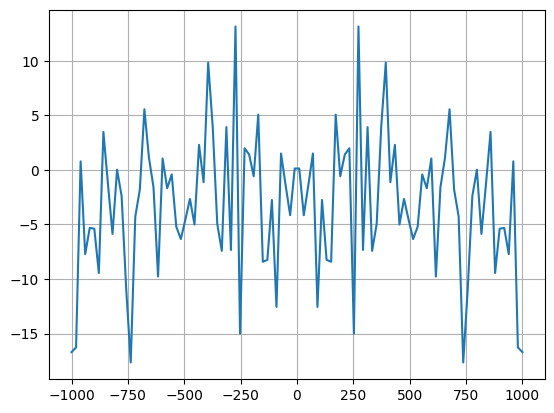

In [417]:
plt.plot(nus*Fs, 10*np.log10(result))
plt.grid()
plt.show()

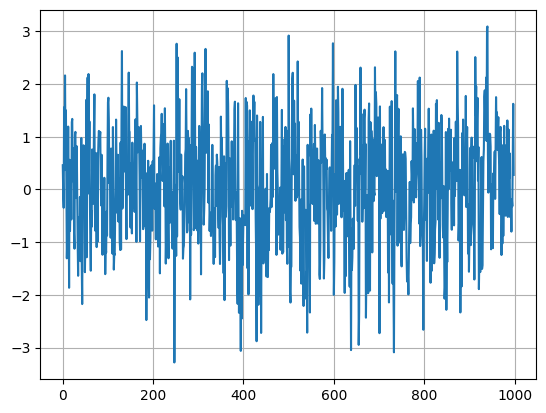

In [418]:
def ARMA(p, q, AR_coeff, MA_coeff, sigma, number_variables):
    
    ARAMA_process = np.zeros(number_variables)
    noise = np.random.normal(0, sigma, number_variables + max(p, q))  
    
    for t in range(max(p, q), number_variables):

        ar_term = 0
        for i in range(1, p+1):
            ar_term += AR_coeff[i-1] * ARAMA_process[t - i]

        ma_term = 0 
        for j in range(1, q+1):
            ma_term += MA_coeff[j-1] * noise[t - j]
        
        ARAMA_process[t] = ar_term + ma_term + noise[t]
    
    return ARAMA_process[max(p, q):]  


def psd_ARMA(AR_coeff, MA_coeff, sigma, nu : list):
    p = len(AR_coeff)
    q = len(MA_coeff)
    
    ar_exp = np.ones((p + 1, len(nu)), dtype=complex)
    ma_exp = np.ones((q + 1, len(nu)), dtype=complex)


    for i in range(1, p+1):
        ar_exp[i, :] = -(AR_coeff[i-1] * np.exp(-2j * np.pi * i * nu))

    for j in range(1, q+1):
        ma_exp[j, :] = MA_coeff[j-1] * np.exp(-2j * np.pi * j * nu)
 
    ma_exp = np.sum(ma_exp, axis = 0)
    ar_exp = np.sum(ar_exp, axis = 0)
 
    ma_exp = pow(np.abs(ma_exp), 2)
    ar_exp = pow(np.abs(ar_exp), 2)
 
    return pow(sigma, 2) * (ma_exp / ar_exp)


AR_COEFFS = [0.5]
MA_COEFFS = [-0.2]
ARMA_process = ARMA(1, 1, AR_COEFFS, MA_COEFFS, SIGMA, 1_000)
plt.plot(ARMA_process)
plt.grid()
plt.show()

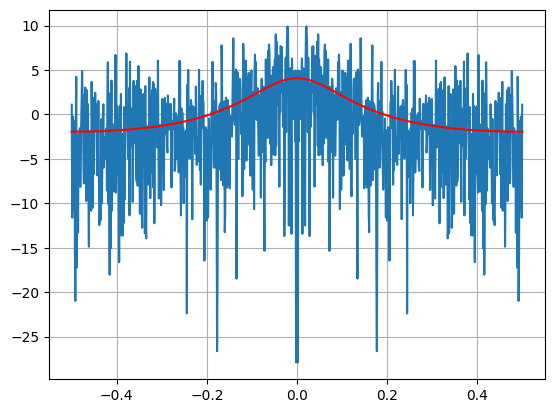

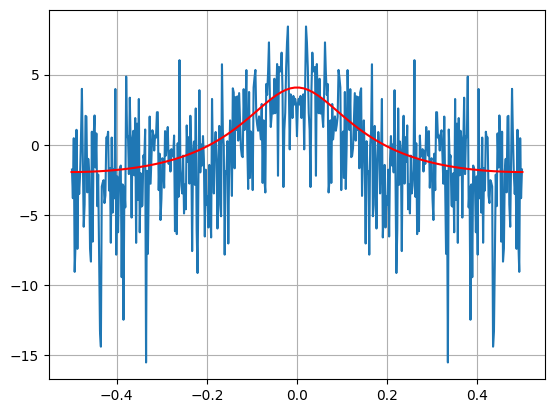

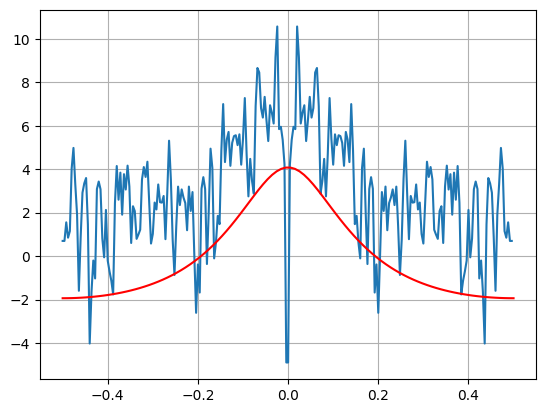

In [419]:
f_arma_sandard, standard_ARMA = periodogram(ARMA_process)
f_arma_bartlett, bartlett_ARMA = periodogram(ARMA_process, method="Bartlett")
f_arma_welch , welch_ARMA = periodogram(ARMA_process, method="Welch")
psd_arma = psd_ARMA(AR_COEFFS, MA_COEFFS, SIGMA, nus)

plt.figure()
plt.grid()
plt.plot(f_arma_sandard, 10*np.log10(standard_ARMA))
plt.plot(nus, 10*np.log10(psd_arma), color='red')
plt.show()

plt.figure()
plt.grid()
plt.plot(f_arma_bartlett, 10*np.log10(bartlett_ARMA))
plt.plot(nus, 10*np.log10(psd_arma), color='red')
plt.show()

plt.figure()
plt.grid()
plt.plot(f_arma_welch, 10*np.log10(welch_ARMA))
plt.plot(nus, 10*np.log10(psd_arma), color='red')
plt.show()

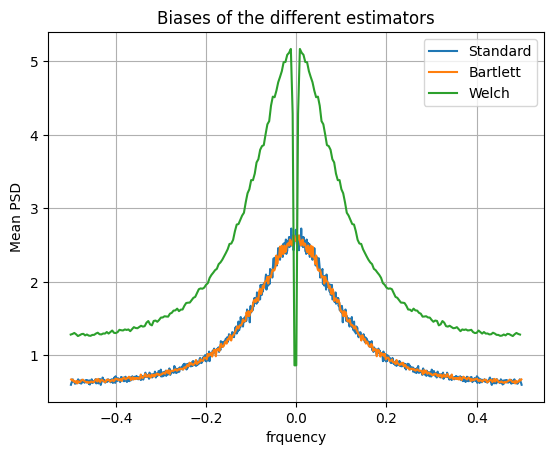

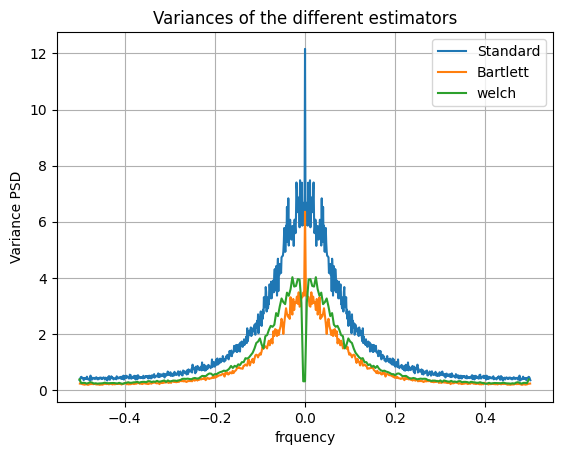

In [420]:
def bias_var_calculator_ARMA(p, q, AR_coeffs, MA_coeffs, sigma, numebr_variables, method):
    """ Bias and Variance Caluclator for the periodogram of an AR process"""
    
    number_tests = 1_000
    AR_process = ARMA(p, q, AR_coeffs, MA_coeffs, sigma, numebr_variables)
    f, _ = periodogram(AR_process, method=method)
    periodogram_list = np.zeros((1_000, len(f)))
    
    for i in range(number_tests):
        ARMA_process = ARMA(p, q, AR_coeffs, MA_coeffs, sigma, numebr_variables)
        _, periodogram_inter = periodogram(ARMA_process, method=method)
        periodogram_list[i, :] = periodogram_inter

    bias_process = np.mean(periodogram_list, axis=0)
    var_process = np.var(periodogram_list, axis=0)
    
    return bias_process, var_process


bias_standard, var_standard = bias_var_calculator_ARMA(1, 1, AR_COEFFS, MA_COEFFS, SIGMA, 1_000, method="standard")
bias_barlett, var_barlett = bias_var_calculator_ARMA(1, 1, AR_COEFFS, MA_COEFFS, SIGMA, 1_000, method="Bartlett")
bias_welch, var_welch = bias_var_calculator_ARMA(1, 1, AR_COEFFS, MA_COEFFS, SIGMA, 1_000, method="Welch")


plt.figure()
plt.title("Biases of the different estimators")
plt.grid()
plt.xlabel("frquency")
plt.ylabel("Mean PSD")
plt.plot(f_arma_sandard, bias_standard, label="Standard")
plt.plot(f_arma_bartlett, bias_barlett, label="Bartlett")
plt.plot(f_arma_welch, bias_welch, label = "Welch")
plt.legend()
plt.show()

plt.figure()
plt.grid()
plt.title("Variances of the different estimators")
plt.xlabel("frquency")
plt.ylabel("Variance PSD")
plt.plot(f_arma_sandard, var_standard, label="Standard")
plt.plot(f_arma_bartlett, var_barlett, label="Bartlett")
plt.plot(f_arma_welch, var_welch, label="welch")
plt.legend()
plt.show()

In [421]:
AR_COEFFS = [0.4, 0.1, 0.2]
MA_COEFFS = [-0.5, 0.7, 0.4, 0.8]
ARMA_process = ARMA(3, 4, AR_COEFFS, MA_COEFFS, SIGMA, 1_000)

The estimated AR coefficients are: [0.18965277 0.21010798 0.23933134], the estimated MA coefficients are: [8.40195456e-02 3.30838096e-01 1.36931108e-04 1.94707893e-01]
 and the estimated sigma is: 0.799118467675589


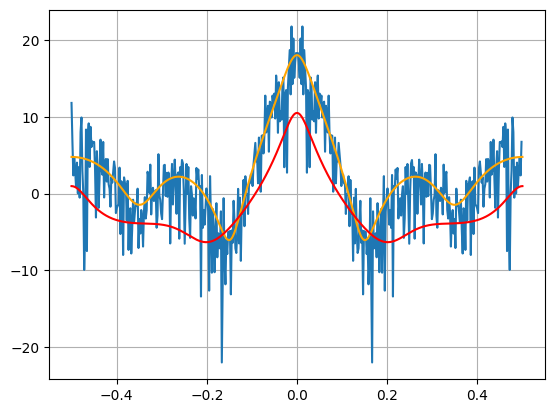

In [424]:
def r_YY(MA_coeffs, sigma, taus):
    """Computes the theoretical autocovariance of the MA process."""
    
    q = len(MA_coeffs)
    b = np.concatenate(([1], MA_coeffs))
    result = np.zeros(len(taus))
    
    for k in range(len(taus)):
        if k > q:
            break
        else:
            result[k] = sum(b[i] * b[i + k] for i in range(q - k + 1))

    return pow(sigma, 2) * result
    
def yule_walker(autocov, order):

    gamma = sp.linalg.toeplitz(autocov)
    approximation = np.linalg.inv(gamma) @ np.array([1 if v == 0 else 0 for v in range(order+1)]).T
    sigma_approximation_square = 1/approximation[0]
    empirical_phis = -(sigma_approximation_square*approximation[1:])
    sigma_approximation = np.sqrt(sigma_approximation_square)
    return empirical_phis, sigma_approximation



def estimate_AR_of_ARMA(p, q, signal):
    """Estimate AR(p) coefficients of an ARMA(p, q) process using Modified Yule-Walker."""
    max_lag = q + p 
    taus = np.arange(max_lag+1)
    autocov = empirical_autocovariance(signal, taus)

    
    r_xx_rhs = autocov[q+1:q+p+1]

    
    gamma = np.array([
        autocov[q + i - j] for i in range(p) for j in range(p)
    ]).reshape((p, p))

    
    a_coeffs = np.linalg.solve(gamma, r_xx_rhs)
    
    return a_coeffs

def durbin(p, q, L, signal, nus):
    """Computes the PSD estimate using durbin Method"""

    taus = np.arange(0, L + 1)
    AR_estimate = estimate_AR_of_ARMA(p, q, signal)
    
    # Estimate the autocovariance of MA process
    signal_inter = np.zeros(len(signal))

    for i in range(p, len(signal)):
        signal_inter[i] = signal[i] - np.sum([
            AR_estimate[j-1] * signal[i-j] for j in range(1, p+1)
        ])

    signal = signal_inter[p:]
    empirical_autotoc = empirical_autocovariance(signal, taus)
    # Solve Yule-Walker for AR(L) for L >> q
    AR_L, sigma_1 = yule_walker(empirical_autotoc, L)
    A_L = np.concatenate(([1], -np.array(AR_L)))
    
    A_L_YY = np.fft.fft(A_L)
    S_YY = pow(sigma_1, 2) / pow(np.abs(A_L_YY), 2)

    # Compute the inverse FFT to get the autocovariance
    r_YY = np.real(np.fft.ifft(S_YY))[:q+1]
    AR_q, sigma_2 = yule_walker(r_YY, q)
    
    
    psd = psd_ARMA(AR_q, AR_estimate, sigma_1 / sigma_2, nus)

    print(f"The estimated AR coefficients are: {AR_estimate}, the estimated MA coefficients are: {AR_q}\n and the estimated sigma is: {sigma_1 / sigma_2}")
    return psd  


nus = np.linspace(-0.5, 0.5, 1_000)
nus_pi = np.linspace(-np.pi, np.pi, 1_000)

psd_estimate = durbin(3, 4, 500, ARMA_process, nus)
psd_arma = psd_ARMA(AR_COEFFS, MA_COEFFS, SIGMA, nus)
f_bartlett, bartlett_ARMA = periodogram(ARMA_process, method="Bartlett")

plt.plot(f_bartlett, 10*np.log10(bartlett_ARMA))
plt.plot(nus, 10*np.log10(psd_arma), color='orange')
plt.plot(nus, 10*np.log10(psd_estimate), color='red')
plt.grid()
plt.show()

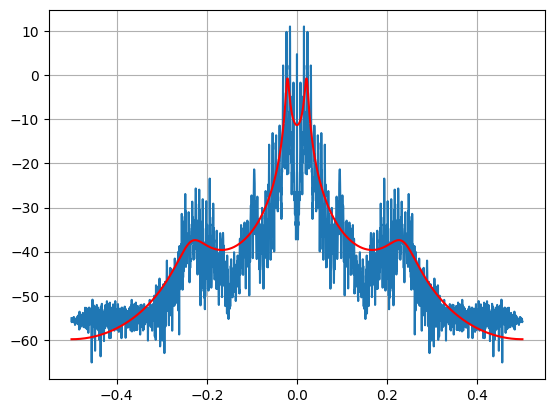

In [425]:
import librosa

x_aninon, sr = librosa.load("an_in_on.wav", sr=None)

start_time = 1.0
end_time = 1.5

end_sample = int(end_time * sr)
start_sample = int(start_time * sr)
x_aninon = x_aninon[start_sample : end_sample]

gamma, sigma, phi_estimates = Gamma(4, x_aninon)

_phi_estimates = np.flip(
    np.append([1],-phi_estimates)
    )

nus_pi = np.linspace(-np.pi, np.pi, 1_000)
f_bartlett, bartlett_ARMA = periodogram(x_aninon, method="Bartlett")
psd_estimate = spectral_density(nus_pi, _phi_estimates, sigma)

plt.plot(f_bartlett, 10*np.log10(bartlett_ARMA))
plt.plot(nus, 10*np.log10(psd_estimate), color='red')
plt.grid()
plt.show()